## Goals

In order to mitigate those issues we’ve decided to implement a minimum delay between two rentals. A car won’t be displayed in the search results if the requested checkin or checkout times are too close from an already booked rental.

It solves the late checkout issue but also potentially hurts Getaround/owners revenues: we need to find the right trade off.

**Our Product Manager still needs to decide:**
* **threshold:** how long should the minimum delay be?
* **scope:** should we enable the feature for all cars?, only Connect cars?

* Which share of our owner’s revenue would potentially be affected by the feature?
* How many rentals would be affected by the feature depending on the threshold and scope we choose?
* How often are drivers late for the next check-in? How does it impact the next driver?
* How many problematic cases will it solve depending on the chosen threshold and scope?

In [2]:
# Data
import pandas as pd
import numpy as np

# Plot
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
data_price = pd.read_csv("../data/get_around_pricing_project.csv")
data = pd.read_excel('../data/get_around_delay_analysis.xlsx')
print(data.columns)
data.rename(columns={
    'rental_id' : 'id',
    'checkin_type' : 'type',
    'delay_at_checkout_in_minutes' : 'delay',
    'previous_ended_rental_id' : 'last_id',
    'time_delta_with_previous_rental_in_minutes' : 'last_delta'
    }, inplace=True)
display(data.sample(5))

print(data.shape[0])

Index(['rental_id', 'car_id', 'checkin_type', 'state',
       'delay_at_checkout_in_minutes', 'previous_ended_rental_id',
       'time_delta_with_previous_rental_in_minutes'],
      dtype='object')


,id,car_id,type,state,delay,last_id,last_delta
12227,521097,379174,mobile,ended,41.0,NaN,NaN
9063,554330,392882,mobile,ended,142.0,543626.0,570.0
14816,566956,403558,mobile,ended,NaN,563099.0,120.0
14916,567919,368269,mobile,canceled,NaN,NaN,NaN
5515,566648,383110,connect,ended,-77.0,568065.0,480.0


21310


In [5]:
data['last_id'].isna().sum()

19469

In [72]:
unaffected_trips = data[data['last_delta'].isna()]

# Add a last delay column that has the delay of the rental that came before it
# This also filters our data to only the points containing last trip information
affected_trips = data[['id', 'delay', 'type', 'state']].rename(columns={
    'id':'last_id',
    'delay':'last_delay',
    'type':'last_type',
    'state':'last_state'
    })
affected_trips = data.merge(affected_trips, on='last_id')
affected_trips.head()

,id,car_id,type,state,delay,last_id,last_delta,last_delay,last_type,last_state
0,511639,370585,connect,ended,-15.0,563782.0,570.0,136.0,connect,ended
1,519491,312389,mobile,ended,58.0,545639.0,420.0,140.0,mobile,ended
2,521156,392479,mobile,ended,NaN,537298.0,0.0,NaN,mobile,ended
3,525044,349751,mobile,ended,NaN,510607.0,60.0,-113.0,mobile,ended
4,528808,181625,connect,ended,-76.0,557404.0,330.0,-352.0,connect,ended


# Insights

* How often are drivers late for the next check-in? How does it impact the next driver?

43.6% of trips have at least 0 minutes of delay
34.8% of trips have at least 15 minutes of delay
19.1% of trips have at least 60 minutes of delay
6.8% of trips have at least 180 minutes of delay
3.2% of trips have at least 360 minutes of delay


<Axes: xlabel='delay', ylabel='Count'>

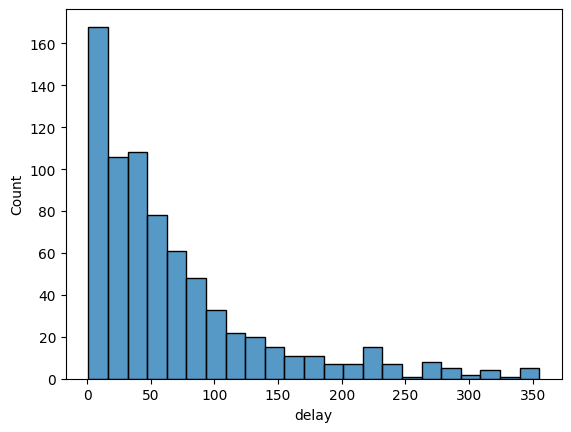

In [73]:
# See amount of trips with over n minutes of delay
for delay in [0, 15, 60, 180, 360]:
    print(
        f"{np.mean(affected_trips['delay'] > delay)*100:.1f}% of trips have at least {delay} minutes of delay"
    )
    
sns.histplot(x=affected_trips.loc[(affected_trips['delay'] > 0) & (affected_trips['delay'] < 360),'delay'])

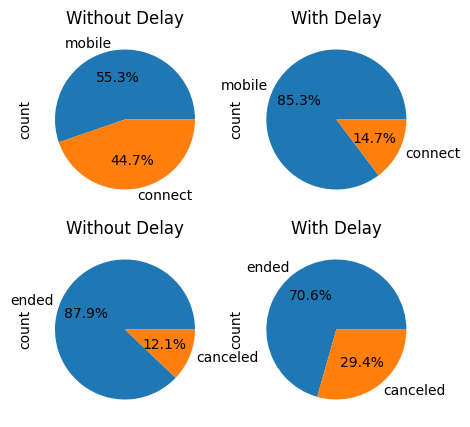

In [74]:
delay_threshold = 360
affected_trips['had_delay'] = affected_trips['last_delay'].apply(lambda x: 1 if x > delay_threshold else 0)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(5, 5))

# Delay rates by status
def plot_impact(delay, col, ax):
    match delay:
        case 0:
            affected_trips.loc[affected_trips['had_delay'] == 0, col].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Without Delay', ax=ax)
        case 1:
            affected_trips.loc[affected_trips['had_delay'] == 1, col].value_counts().plot(kind='pie', autopct='%1.1f%%', title='With Delay', ax=ax)

for x in [0, 1]:
    for y in [0, 1]:     
        col = 'type' if x == 0 else 'state'
        plot_impact(y, col, axes[x, y])

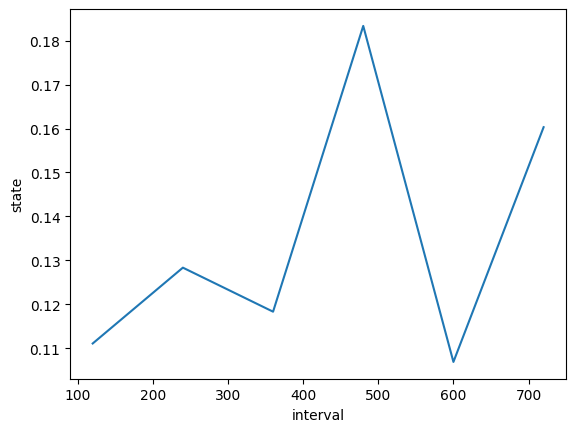

In [75]:



def plot_interval_cancels(df, n_interval):
    df = df.copy()
    df['interval'] = df['last_delta'].apply(categorize, args=(n_interval,))
    df['state'] = df['state'].map({'ended':0, 'canceled':1})
    df = df.groupby('interval')['state'].mean()
    sns.lineplot(df)
    plt.show()

plot_interval_cancels(affected_trips, 6)

multi line plot of evolution of states as delay increases could be interesting

# Optimization

For a given threshold and scope, how many cancellations and late check-ins can we avoid? What is the revenue loss of this?

In [76]:
def min_delay(df, threshold, scope='all'):
    # Filter data to find trips to drop
    df_delay = df[(df['last_delta'] < threshold)]
    if scope != 'all':
        df_delay = df_delay[df_delay['type'] == scope]
    
    state_mask = df_delay['state'] == 'ended'
    dt_e = df_delay[state_mask]
    dt_c = df_delay[~state_mask]
    
    return dt_e.shape[0], dt_c.shape[0]

In [105]:
results = pd.DataFrame(columns=['delay', 'scope', 'rev_loss', 'fri_loss', 'precision', 'recall', 'f1', 'dte', 'dtc'])

for scope in ['all', 'mobile', 'connect']:
    for delay in np.geomspace(1, 720, 100):
        dt_e, dt_c = min_delay(affected_trips, delay, scope)
        uc_cnt = unaffected_trips[unaffected_trips['state'] == 'canceled'].shape[0]
        ac_cnt = affected_trips[affected_trips['state'] == 'canceled'].shape[0]
        precision = dt_c/(dt_c+dt_e)*100
        recall = dt_c/affected_trips[affected_trips['state'] == 'canceled'].shape[0]*100
        results.loc[len(results),] = [
            int(delay),
            scope,
            (dt_e-dt_c) / data.shape[0]*100,
            dt_c/ac_cnt*100,
            precision,
            recall,
            2/(1/precision+1/recall),
            dt_e,
            dt_c
            ]

<Axes: xlabel='fri_loss', ylabel='rev_loss'>

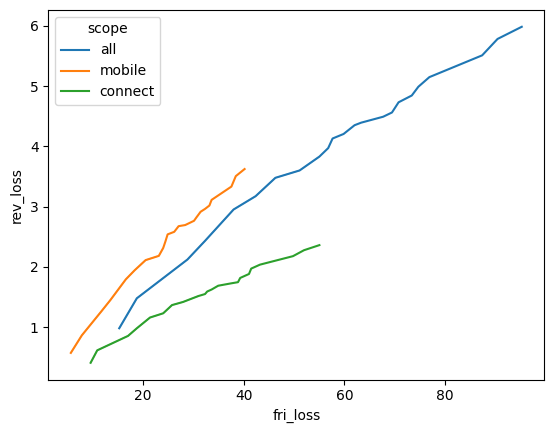

In [106]:
sns.lineplot(
    data=results, x='fri_loss', y='rev_loss', hue='scope'
)

<Axes: xlabel='delay', ylabel='rev_loss'>

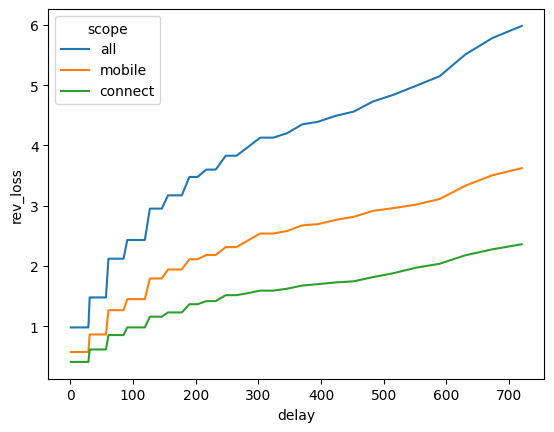

In [110]:
sns.lineplot(
    data=results, x='delay', y='rev_loss', hue='scope'
)

In [112]:
unaffected_trips['type'].value_counts()

type
mobile     15975
connect     3494
Name: count, dtype: int64

In [111]:
affected_trips['type'].value_counts()

type
mobile     1028
connect     813
Name: count, dtype: int64